In [3]:
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import pandas as pd
import warnings
import time
import seaborn
from torch import nn
from typing import Optional,Union,List,Tuple
from torchvision import transforms
import re

### 搭建LSTM

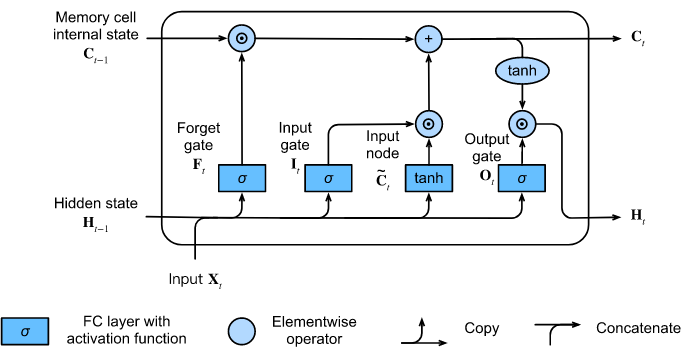<br>
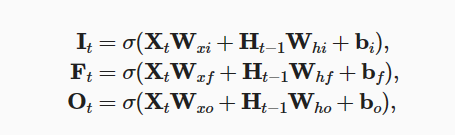<br>
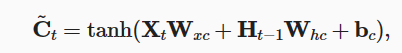<br>
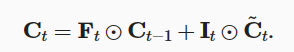<br>
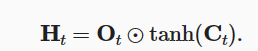

In [13]:
class MyLSTM(nn.Module):
    def __init__(self, n_inputs, n_hiddens, var=0.01) -> None:
        super().__init__()
        self.n_inputs = n_inputs
        self.n_hiddens = n_hiddens
        shape = (n_inputs, n_hiddens)
        # 按方差为0.01正态分布随机初始化权重
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * var)
        # 由上图可知,每一个门的参数都是一个三元组
        triple = lambda: (init_weight(n_inputs, n_hiddens),
                init_weight(n_hiddens, n_hiddens),
                nn.Parameter(torch.zeros(n_hiddens))
                )
        self.wx_i, self.wh_i, self.b_i = triple()# 输入门
        self.wx_f, self.wh_f, self.b_f = triple()# 遗忘门
        self.wx_o, self.wh_o, self.b_o = triple()# 输出门
        self.wx_c, self.wh_c, self.b_c = triple()# input node

    def forward(self, inputs:torch.Tensor, H_C:Union[tuple,list]=None):
        """

        Args:
            inputs (torch.Tensor): (n_steps, batch_size, n_inputs)
            H_C (Union[tuple,list], optional): 由上一隐层H_t-1和记忆单元C_t-1组成的元组. Defaults to None.
        """            
        if H_C is None:
            # shape:(batch_size, n_hiddens)
            H = torch.zeros(inputs.shape[1], self.n_hiddens, device=inputs.device)
            C = torch.zeros(inputs.shape[1], self.n_hiddens, device=inputs.device)
        else:
            H, C = H_C
        
        outputs = []
        for X in inputs:
            I = torch.sigmoid(torch.matmul(X, self.wx_i) +
                        torch.matmul(H, self.wh_i) + self.b_i)
            F = torch.sigmoid(torch.matmul(X, self.wx_f) +
                            torch.matmul(H, self.wh_f) + self.b_f)
            O = torch.sigmoid(torch.matmul(X, self.wx_o) +
                            torch.matmul(H, self.wh_o) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(X, self.wx_c) +
                            torch.matmul(H, self.wh_c) + self.b_c)
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        
        return torch.stack(outputs,dim=0), (H, C)

# test forward
n_steps, batch_size, n_inputs, n_hiddens = 5, 64, 100, 60
temp = torch.rand(n_steps, batch_size, n_inputs)
lstm = MyLSTM(n_inputs, n_hiddens)
# 5,64, 60 (100 when there is a fc layer)
lstm(temp)[0].shape

torch.Size([5, 64, 60])

### 搭建GRU


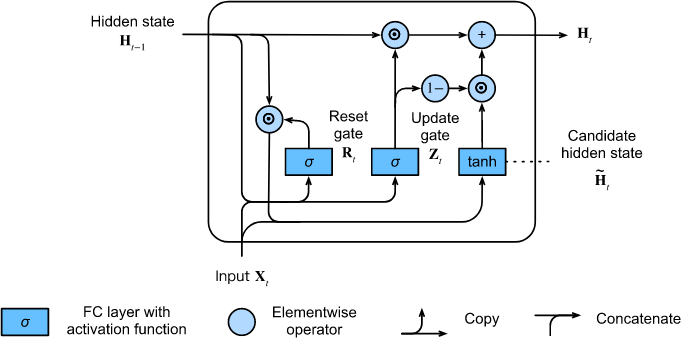<br>
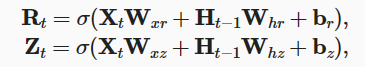<br>
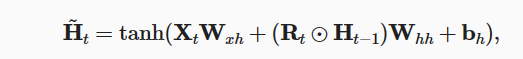<br>


In [14]:
# similar to the LSTM
class MyGRU(nn.Module):
    def __init__(self, n_inputs, n_hiddens, var=0.01) -> None:
        super().__init__()
        self.n_inputs = n_inputs
        self.n_hiddens = n_hiddens
        shape = (n_inputs, n_hiddens)
        # 按方差为0.01正态分布随机初始化权重
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * var)
        # 由上图可知,每一个门的参数都是一个三元组
        triple = lambda: (init_weight(n_inputs, n_hiddens),
                init_weight(n_hiddens, n_hiddens),
                nn.Parameter(torch.zeros(n_hiddens))
                )
        self.wx_r, self.wh_r, self.b_r = triple()# reset门
        self.wx_z, self.wh_z, self.b_z = triple()# update门
        self.wx_h, self.wh_h, self.b_h = triple()# Candidate hidden state
    
    def forward(self, inputs:torch.Tensor, H:torch.Tensor=None):
        """

        Args:
            inputs (torch.Tensor): (n_steps, batch_size, n_inputs)
            H (torch.Tensor): 上一隐层传入的 H_t-1. Defaults to None.
        """            
        if H is None:
            # shape:(batch_size, n_hiddens)
            H = torch.zeros(inputs.shape[1], self.n_hiddens, device=inputs.device)
        
        outputs = []
        for X in inputs:
            R = torch.sigmoid(torch.matmul(X, self.wx_r) +
                        torch.matmul(H, self.wh_r) + self.b_r)
            Z = torch.sigmoid(torch.matmul(X, self.wx_z) +
                            torch.matmul(H, self.wh_z) + self.b_z)
            H_tilde = torch.tanh(torch.matmul(X, self.wx_h) +
                            torch.matmul(R * H, self.wh_h) + self.b_h)
            
            H = H * Z + (1 - Z) * H_tilde
            outputs.append(H)
        
        return torch.stack(outputs), H
# test forward
temp = torch.rand(n_steps, batch_size, n_inputs)
gru = MyGRU(n_inputs, n_hiddens)
# 5,64, 60 (100 when there is a fc layer)
gru(temp)[0].shape

torch.Size([5, 64, 60])